# Plot the Light Curve 
Plot the light curve of the target using the relative flux to those of your comparisons. <br>
You should input the TARGETNUM and COMPNUMS, and check the additional parameters such as TARGETNAME, OBSDATE in **tape.par**. 


Read the parameters in **tape.par**, and move to the working directory.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits 
from photlib import read_params, prnlog, sigma_clip

# READ the parameter file
par = read_params()

# TARGET information
WORKDIR = par['WORKDIR']
PHOT_APER = np.array(par['PHOTAPER'].split(','), float)   # Radius of aperture
N_APER = len(PHOT_APER)
T_APER = int(par['APERUSED']) # index of used aperture
TNUM1 = int(par['TARGETNUM'])  # Index of the target for variability
OBSDATE, TARGET = par['OBSDATE'], par['TARGETNAM']  # Obs. info. 
WNAME = OBSDATE+'-'+TARGET  # file name to save data 
CLIST1 = np.array(par['COMPNUMS'].split(','), int) # Indices of the comparisons
LOGFILE = par['LOGFILE']

prnlog('#WORK: plot_lightcurve')
prnlog(f'#WORKNAME: {WNAME}')
prnlog(f'#APERTURE: [{T_APER}] R={PHOT_APER[T_APER-1]}pix')
prnlog(f'#TARGET: {TARGET}')
prnlog(f'#TARGET INDEX: {TNUM1}')
prnlog(f'#COMPARISON INDICES: {CLIST1}')
prnlog(f'#LOGFILE: {LOGFILE}')

# MOVE to the working directory =======
CDIR = os.path.abspath(os.path.curdir)
os.chdir(WORKDIR)
#======================================


c:\Users\kang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#WORK: plot_lightcurve
#WORKNAME: 180326-HAT-P-12b
#APERTURE: [2] R=20.0pix
#TARGET: HAT-P-12b
#TARGET INDEX: 13
#COMPARISON INDICES: [10 17 21]
#LOGFILE: wobs.log


Read the observation log file, and convert the target number into the index of the time-series array. 

In [2]:
# CONVERT number into index
TNUM = TNUM1 - 1

# READ the time-series log file 
flog = open(LOGFILE,'r')
lfrm, lname, lJD, lFILTER = [], [], [], [] 
for line in flog:
    tmp = line.split()
    lfrm.append(int(tmp[0]))
    lname.append(tmp[1])
    lJD.append(float(tmp[2]))
    lFILTER.append(tmp[5])
FRM, FLIST, JD = np.array(lfrm), np.array(lname), np.array(lJD)
#FILTER = lFILTER[0]
flog.close()


Mark the target and comparisons in the finding-chart. 

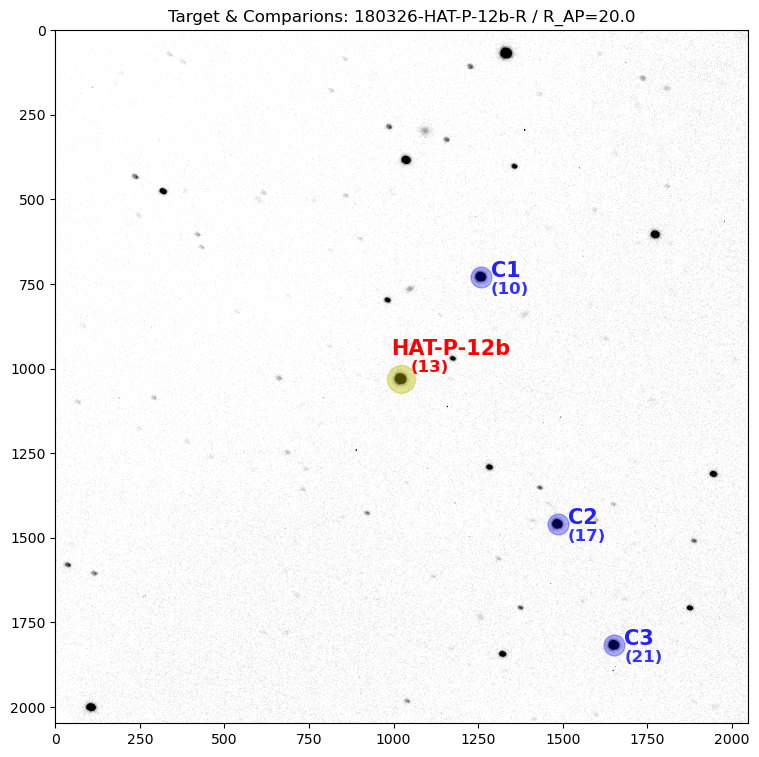

In [4]:
# SHOW the first image 
hdu = fits.open(FLIST[0]+'.fits')
FILTER = hdu[0].header['FILTER']
img = hdu[0].data
ny, nx = img.shape
iavg, imed, istd = sigma_clip(img)
fig, ax = plt.subplots(num=1, figsize=(9,9), dpi=100)
z1, z2 = imed, imed+istd*8
ax.imshow(-img, vmin=-z2, vmax=-z1, cmap='gray')

# READ the time-series data 
dat = np.genfromtxt(FLIST[0]+'.apx')
snum, xpix, ypix = dat[:,0], dat[:,1], dat[:,2]
NSTARS = len(snum)
# LOOP for marking the comparisons
for j, cidx in enumerate(CLIST1):
    cidx = cidx - 1
    ax.plot(xpix[cidx], ypix[cidx], 'bo', alpha=0.3, ms=15)
    ax.text(xpix[cidx]+30, ypix[cidx], f'C{j+1:d}', fontweight='bold', fontsize=15, color='#2222FF')
    ax.text(xpix[cidx]+30, ypix[cidx]+50, f'({snum[cidx]:.0f})', fontweight='bold', fontsize=12, color='#3333FF')
# MARK the target
ax.plot(xpix[TNUM], ypix[TNUM], 'yo', alpha=0.4, ms=20)
ax.text(xpix[TNUM]-30, ypix[TNUM]-70, TARGET, fontweight='bold', fontsize=15, color='r')
ax.text(xpix[TNUM]+30, ypix[TNUM]-20, f'({TNUM+1})', fontweight='bold', fontsize=12, color='r')
ax.set_xlim(0,nx)
ax.set_ylim(ny,0)
ax.set_title(f'Target & Comparions: {WNAME}-{FILTER} / R_AP={PHOT_APER[T_APER-1]:.1f}')
fig.savefig(f'w{WNAME}-{FILTER}-mark.png')



Read the time-series photometry file(.apx) and make the arrays of flux and errors 

In [5]:
# READ the apx files
FLX, ERR, MAG, MRR, FLG = [], [], [], [], []
for i, fidx in enumerate(FLIST):
    dat = np.genfromtxt(fidx+'.apx')
    FLX.append(dat[:,(T_APER+2)])
    ERR.append(dat[:,(N_APER+T_APER+2)])
    MAG.append(dat[:,(2*N_APER+T_APER+2)])
    MRR.append(dat[:,(3*N_APER+T_APER+2)])
    FLG.append(dat[:,(4*N_APER+4)])

# MAKE the arrays of photometric results by JDs and stars
# row: frames(time), col: stars(mag, flux) 
FLX, ERR = np.array(FLX), np.array(ERR)
MAG, MRR = np.array(MAG), np.array(MRR)
FLG = np.array(FLG)

# TARGET arrays
TFLX, TERR, TMAG, TMRR, TFLG = \
  FLX[:,TNUM], ERR[:,TNUM], MAG[:,TNUM], MRR[:,TNUM], FLG[:,TNUM]

Plot the differential magnitudes, relative to each comparison. 

180326-HAT-P-12b / MAG PLOT: 013-010
180326-HAT-P-12b / MAG PLOT: 013-017
180326-HAT-P-12b / MAG PLOT: 013-021


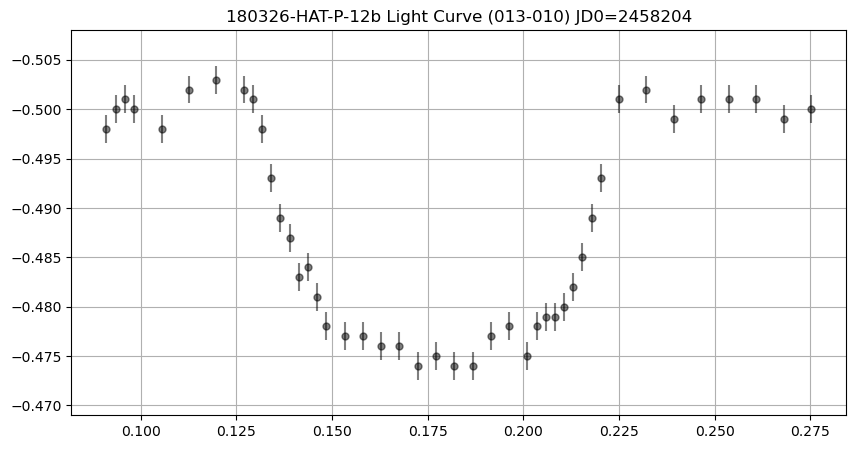

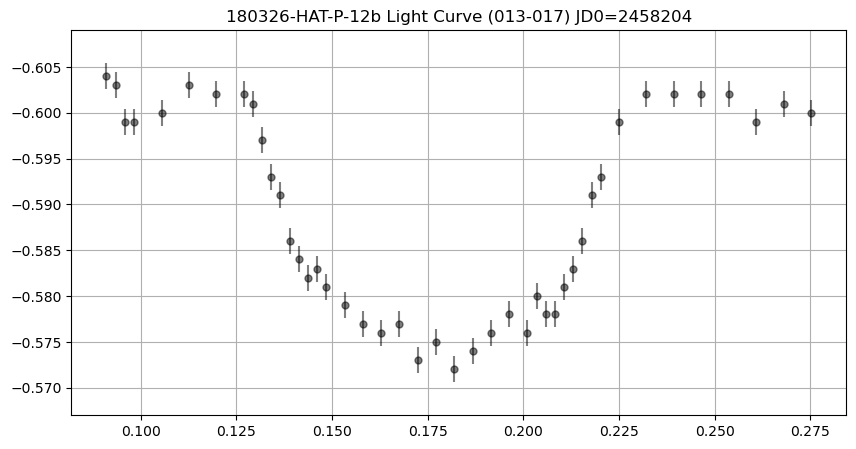

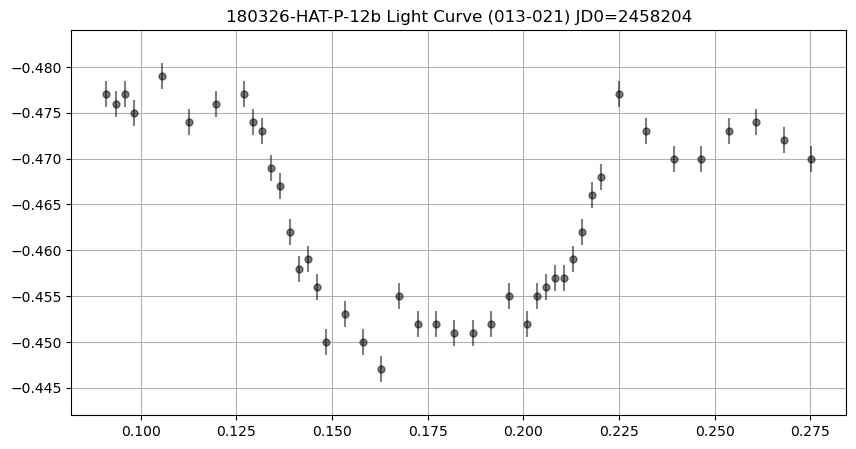

In [7]:
JD0 = int(JD[0])
# LOOP for stars ==========================================
for cidx1 in CLIST1:
    # CONVERT number into index
    cidx = cidx1 - 1 
    prnlog(f'{WNAME} / MAG PLOT: {TNUM1:03d}-{cidx1:03d}')
    # PLOT the light curves of magnitude for each star  
    fig, ax = plt.subplots(figsize=(10,5))
    y = TMAG - MAG[:,cidx]
    yerr = np.sqrt(TMRR**2 + MRR[:,cidx]**2)
    vv, = np.where(TFLG+FLG[:,cidx] == 0)
    ax.errorbar(JD[vv]-JD0,y[vv],yerr=yerr[vv],fmt='ko',ms=5, alpha=0.5)
    ax.set_ylim(np.max(y[vv])+0.005,np.min(y[vv])-0.005)
    ax.set_title(f'{WNAME} Light Curve ({TNUM1:03d}-{cidx1:03d}) JD0={JD0:d}')
    ax.grid()
    fig.savefig(f'w{WNAME}-{FILTER}-LC-MAG-{cidx1:03d}.png')
    
    # WRITE the magintude difference for each comparison
    fmag = open(f'w{WNAME}-{FILTER}-LC-MAG-{cidx1:03d}.txt', 'w')
    for vidx in vv:
        fmag.write(f'{JD[vidx]:16.8f} {y[vidx]:8.5f} {yerr[vidx]:8.5f} \n')
    fmag.close()

Plot the light curve of target, relatve to the total fluxes of all comparisons, and write the result to the text file. <br>
You may change the comparison list (**CLIST1** or **cc**)

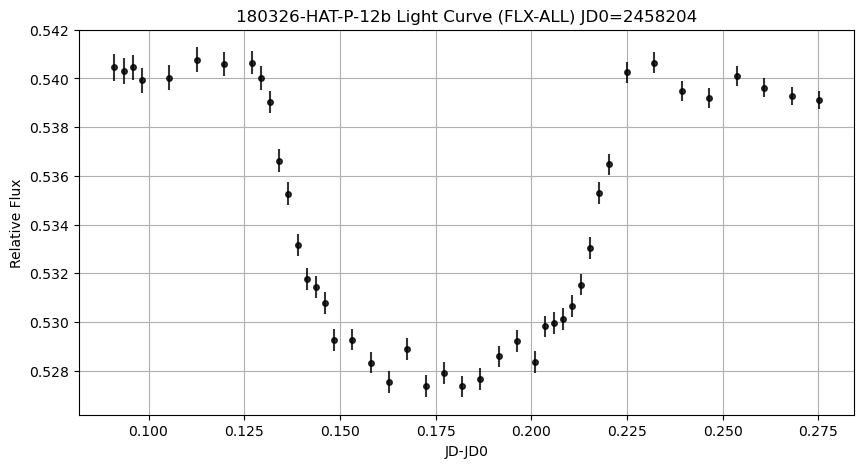

In [8]:
# CALC. the flux ratio between target and comparisons    
cc = np.array(CLIST1) - 1 
CFLX = np.sum(FLX[:,cc], axis=1)
CERR = np.sqrt(np.sum(ERR[:,cc]**2, axis=1))
SFLX = TFLX / CFLX
SERR = np.sqrt(((TFLX/CFLX**2)**2)*(CERR**2) + ((1.0/CFLX)**2)*(TERR**2))
SFLG = TFLG + np.sum(FLG[:,cc], axis=1)
vv, = np.where(SFLG == 0)
x1, x2 = np.min(JD[vv]-JD0), np.max(JD[vv]-JD0)

# PLOT the light curve by flux 
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(JD[vv]-JD0, SFLX[vv], yerr=SERR[vv], fmt='ko', ms=4, mew=1, alpha=0.8)
ax.set_title(f'{WNAME} Light Curve (FLX-ALL) JD0={JD0:d}')
ax.grid()
ax.set_xlabel('JD-JD0')
ax.set_ylabel('Relative Flux')
fig.savefig(f'w{WNAME}-{FILTER}-LC-FLX.png')
    
# WRITE the light curve of flux ratio 
fout = open(f'w{WNAME}-{FILTER}.dat', 'w')
for vidx in vv:
    fout.write(f'{JD[vidx]:.8f} {SFLX[vidx]:12.8f} {SERR[vidx]:12.8f}\n')
fout.close()

Plot the differential magnitude among the comparisons, and verify the comparisons. <br>
Return to the directory

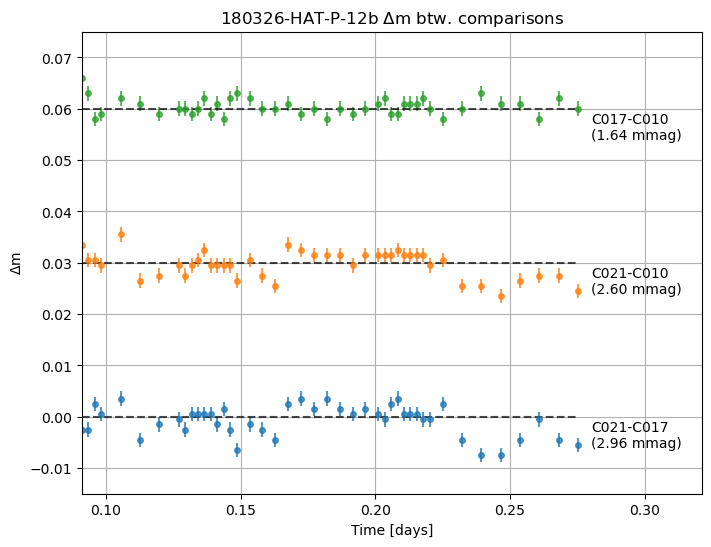

In [9]:
NCOMP = len(CLIST1)
H = max([6,NCOMP*(NCOMP-1)/2])
fig, ax = plt.subplots(figsize=(8,H))
if NCOMP > 1:
    M0, dM0 = 0.0, 0.03
    for i in range(NCOMP-1,-1,-1):
        for j in range(i-1,-1,-1):
            c1 = CLIST1[i]-1
            c2 = CLIST1[j]-1
            chkG = FLG[:,c1] + FLG[:,c2]
            vv, = np.where(chkG == 0)
            
            chkE = np.sqrt(MRR[:,c1]**2+MRR[:,c2]**2)
            chkM = MAG[:,c1]-MAG[:,c2]
            m = np.median(chkM[vv])
            chkM = chkM[vv] - m 
            chkE = chkE[vv]
            chkT = JD[vv] - JD0
            RMS = np.std(chkM)
            ax.errorbar(chkT, chkM+M0, yerr=chkE, fmt='o', ms=4, alpha=0.75)
            clabel= f'C{c1+1:03d}-C{c2+1:03d}\n({RMS*1000:.2f} mmag)'
            ax.text(np.max(chkT)+0.005,M0-0.2*dM0, clabel)    
            ax.plot(chkT,np.zeros_like(chkT)+M0,'k--',alpha=0.7)
            M0 = M0+dM0
    ax.grid()
    ax.set_ylim(-dM0/2, M0-dM0/2)
    ax.set_xlim(x1, x2+(x2-x1)*0.25)
    ax.set_ylabel('$\Delta$m')
    ax.set_xlabel('Time [days]')
    ax.set_title(f'{WNAME} $\Delta$m btw. comparisons')
    fig.savefig(f'w{WNAME}-{FILTER}-COMPS.png')


Return to the directory

In [ ]:
# RETURN to the directory =============
os.chdir(CDIR)
#======================================